# Contexto do problema

A diversidade e amplitude de clientes que utilizam a plataforma do iFood é gigante - a cobertura do aplicativo se estende 
por muitas geografias no Brasil, de múltiplos gostos, regionalismos e bolsos.<br> 
Alguns buscam uma experiência no momento da refeição, outros só querem receber a marmita na hora certa para não se atrasar para a primeira reunião pós-almoço.
<br>
Neste contexto, precisamos entender melhor nossos clientes!<br>
- Quem é o mais fiel e quem mais compra conosco? Quem mais gosta de cupom?<br>
- Quem gosta de entrega grátis? Qual o padrão de consumo?<br>
- Qual o padrão de comportamento? Quanto os clientes vão gastar? Onde?<br>

Total de 20.249 clientes diferentes, únicos e anonimizados, na base, que realizaram 226.269 pedidos, em 7 meses (fev20 a set20), através de mais de 5 milhões de sessões abertas no aplicativo.

# 1.Importando bibliotecas e datasets

In [23]:
# Análise e visualização de dados
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import SilhouetteVisualizer

# Transformações e pré-processamento
from haversine import haversine, Unit
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler

# Modelos e métricas
from kmodes.kmodes import KModes
from dython.nominal import associations
from kmodes.kprototypes import KPrototypes
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, DBSCAN, Birch, OPTICS

plt.style.use('ggplot')

pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
mkt = pd.read_csv('data/marketing.xls', sep=";", parse_dates=['first_order_date', 'registration_date'])

pedidos = pd.read_csv('data/orders.xls', sep=";", parse_dates=['review_created_at', 'confirmed_date', 'concluded_date'])

sessoes = pd.read_csv('data/sessions.xls', sep=";", parse_dates=['session_started', 'session_ended'])

# 2.Informações básicas

- Dimensões do dataset

In [71]:
print(f'- Marketing: {mkt.shape}')
print(f'- Sessões: {sessoes.shape}')
print(f'- Pedidos: {pedidos.shape}')

- Marketing: (20249, 6)
- Sessões: (3591511, 15)
- Pedidos: (226269, 34)


In [5]:
mkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account_id               20249 non-null  object        
 1   registration_date        20249 non-null  datetime64[ns]
 2   ifood_status             20249 non-null  object        
 3   ifood_status_last_month  20249 non-null  object        
 4   total_order_count        20249 non-null  int64         
 5   first_order_date         20248 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 949.3+ KB


In [6]:
sessoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 15 columns):
 #   Column                      Dtype              
---  ------                      -----              
 0   session_id                  object             
 1   user_account_uuid           object             
 2   session_started             datetime64[ns, UTC]
 3   session_ended               datetime64[ns, UTC]
 4   install_timestamp           object             
 5   sum_view_restaurant_screen  int64              
 6   sum_view_dish_screen        int64              
 7   sum_click_add_item          int64              
 8   sum_view_checkout           int64              
 9   sum_callback_purchase       int64              
 10  first_order_has_voucher     object             
 11  media_campaign              object             
 12  load_time                   float64            
 13  available_restaurants       float64            
 14  rownumber                   int64 

In [7]:
pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   order_id              226269 non-null  object             
 1   order_shift           226269 non-null  object             
 2   order_origin          226269 non-null  object             
 3   delivery_fee          226269 non-null  float64            
 4   scheduled             226269 non-null  bool               
 5   total_amount          226269 non-null  float64            
 6   subsidy_amount        226269 non-null  float64            
 7   device_platform       226269 non-null  object             
 8   device_type           226269 non-null  object             
 9   device_app_version    221834 non-null  object             
 10  centroid_id           226269 non-null  object             
 11  state_label           226269 non-null  object       

In [8]:
# Averiguando colunas nos datasets
print(mkt.columns)
print(pedidos.columns)
print(sessoes.columns)

Index(['account_id', 'registration_date', 'ifood_status',
       'ifood_status_last_month', 'total_order_count', 'first_order_date'],
      dtype='object')
Index(['order_id', 'order_shift', 'order_origin', 'delivery_fee', 'scheduled',
       'total_amount', 'subsidy_amount', 'device_platform', 'device_type',
       'device_app_version', 'centroid_id', 'state_label', 'city', 'district',
       'customer_long', 'customer_lat', 'restaurant_id', 'dish_type',
       'group_id', 'merchant_centroid_id', 'merchant_state', 'merchant_city',
       'merchant_district', 'merchant_zipcode', 'merchant_long',
       'merchant_lat', 'has_free_delivery', 'confirmed_date', 'concluded_date',
       'lag_last_order', 'account_id', 'review_score', 'nps_score',
       'review_created_at'],
      dtype='object')
Index(['session_id', 'user_account_uuid', 'session_started', 'session_ended',
       'install_timestamp', 'sum_view_restaurant_screen',
       'sum_view_dish_screen', 'sum_click_add_item', 'sum_view_

## Dados faltantes

In [3]:
# Excluindo duplicatas
mkt.drop_duplicates(inplace=True)
pedidos.drop_duplicates(inplace=True)
sessoes.drop_duplicates(inplace=True)

In [4]:
# Função para detecção de NaN
def dados_ausentes(dataframe, nome = None):
    """
    Função para detecção de dados NaN

    Args:
        dataframe: qualquer dataframe
        nome (str, optional): Nome do dataframe. Defaults é None.

    Returns:
        dataframe: dataframe organizado com tipo de dados, quantidade e porcentagens
    """
    
    lista_coluna = []
    lista_valor_isna = []
    lista_porcent_isna = []
    lista_tipo_var = []

    for item in dataframe.columns:
        if dataframe[item].isna().sum() > 0:
            lista_coluna.append(item)
            lista_valor_isna.append(dataframe[item].isna().sum())
            lista_porcent_isna.append(round(dataframe[item].isna().sum()/dataframe.shape[0]*100, 3))
            lista_tipo_var.append(dataframe[item].dtype)

    dataframe_status = pd.DataFrame({"Coluna": lista_coluna, "Tipo": lista_tipo_var, "Contagem": lista_valor_isna,  
                            "%": lista_porcent_isna}).sort_values('Contagem', ascending=False).reset_index(drop=True)
    nome = str(nome).upper()
    
    print(f'COLUNAS DO DATASET {nome} COM VALORES NaN:')
    
    return dataframe_status

In [102]:
dados_ausentes(mkt, nome = "marketing")

COLUNAS DO DATASET MARKETING COM VALORES NaN:


,Coluna,Tipo,Contagem,%
0,first_order_date,datetime64[ns],1,0.01


In [103]:
dados_ausentes(sessoes, nome = 'sessões')

COLUNAS DO DATASET SESSÕES COM VALORES NaN:


,Coluna,Tipo,Contagem,%
0,install_timestamp,object,3579968,99.68
1,media_campaign,object,3538088,98.51
2,first_order_has_voucher,object,3170881,88.29
3,load_time,float64,743400,20.70
4,session_ended,"datetime64[ns, UTC]",45745,1.27


In [104]:
dados_ausentes(pedidos, nome = 'pedidos')

COLUNAS DO DATASET PEDIDOS COM VALORES NaN:


,Coluna,Tipo,Contagem,%
0,device_app_version,object,4435,1.96
1,lag_last_order,float64,184,0.08
2,confirmed_date,"datetime64[ns, UTC]",14,0.01
3,concluded_date,"datetime64[ns, UTC]",4,0.00


<Axes: >

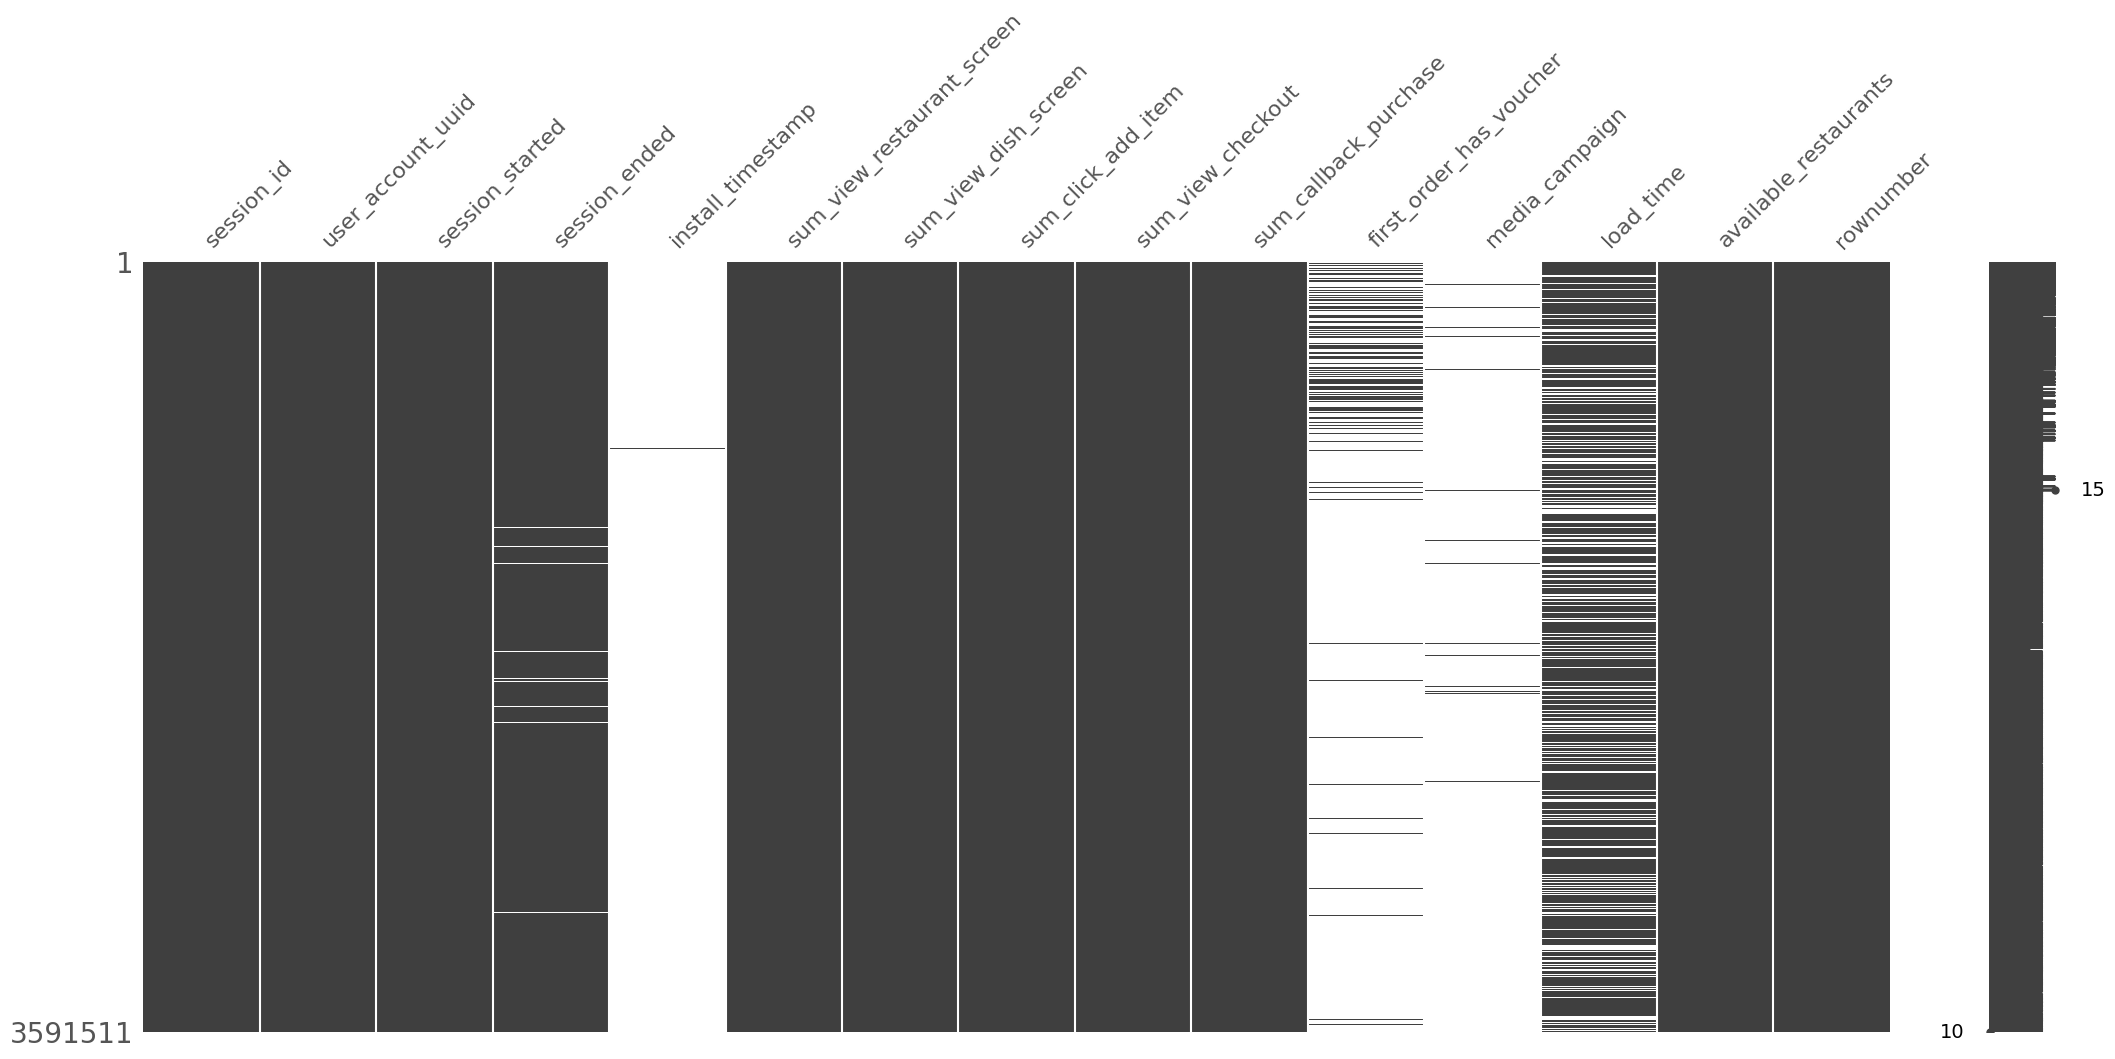

In [ ]:
msno.matrix(sessoes)

In [5]:
# Excluindo colunas com predominancia de NaN
sessoes.drop(columns=['install_timestamp', 'first_order_has_voucher', 'media_campaign', 'rownumber'], axis=1, inplace=True)

## Verificando usuários/clientes

In [6]:
usuarios_mkt = len(mkt['account_id'].unique())
usuarios_sessoes = len(sessoes['user_account_uuid'].unique())
usuarios_pedidos = len(pedidos['account_id'].unique())
total_pedidos = mkt['total_order_count'].sum()
total_receita = pedidos['total_amount'].sum()

print(f"Total de {total_pedidos} pedidos: totalizando {total_receita} reais de receita.")

Total de 6911413 pedidos: totalizando 1361643703.75 reais de receita.


In [7]:
df_usuarios = pd.DataFrame({"Usuários": ['Cadastrados', 'Iniciaram sessão', 'Efetuaram compras'],
                            "Total": [usuarios_mkt, usuarios_sessoes, usuarios_pedidos],
                            "%": [100, round((usuarios_sessoes*100)/usuarios_mkt, 2), round((usuarios_pedidos*100)/usuarios_mkt, 2)]})

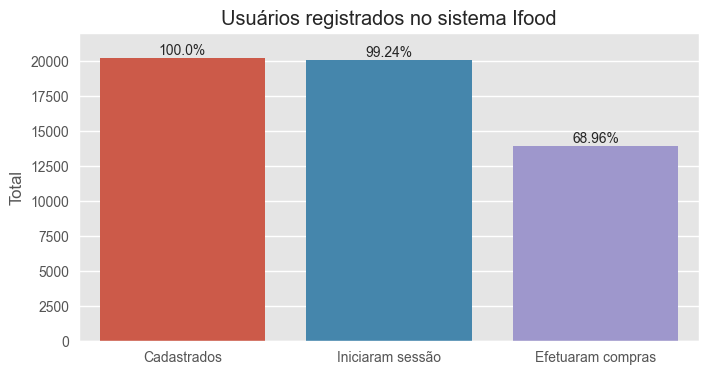

In [135]:
plt.figure(figsize=(8,4))

plt.title('Usuários registrados no sistema Ifood')

ax = sns.barplot(df_usuarios, x = 'Usuários', y = 'Total')
ax.set_ylim([0, 22_000])
ax.set_xlabel('')

for index, row in df_usuarios.iterrows():
    ax.text(x=index, y=row['Total'], s=f"{row['%']}%", ha='center', va='bottom')

- Usuários:
    - Do total registrado 68.96% efetuaram compras
    - Foram feitos 6911413 pedidos gerando receita de R$ 1.361.643.703,75 (Acima de 1Bi)

Logo de início temos 2 questionamentos que podem ser explorados, porém não serão investigados nessa análise:
- Qual perfil de quem não iniciou sessões?
- Qual perfil de quem iniciou sessões mas não comprou?

# 3.Análise exploratória

## Marketing

In [138]:
mkt.head(2)

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19


### Quantidade de pedidos por cliente

,count,mean,std,min,25%,50%,75%,max
total_order_count,20249.00,341.32,303.15,0.00,91.00,286.00,501.00,3098.00


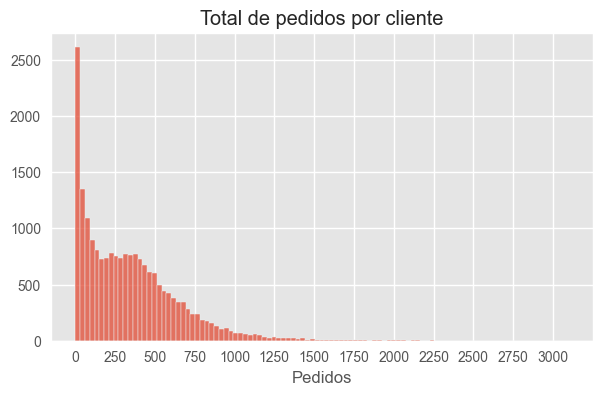

In [82]:
plt.figure(figsize=(7,4))

sns.histplot(mkt, x = 'total_order_count')
plt.title("Total de pedidos por cliente")
plt.xlabel("Pedidos")
plt.ylabel("")
plt.xticks(range(0,3200, 250))

# Descritiva
mkt['total_order_count'].describe().to_frame().T


### Status atual da conta

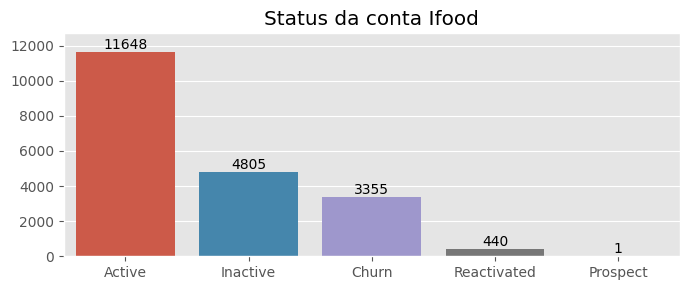

In [84]:
plt.figure(figsize=(7,3))

ax = sns.countplot(mkt, x='ifood_status', order=mkt['ifood_status'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title('Status da conta Ifood')
plt.ylim([0,12700])
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()


### Status da conta no mês anterior

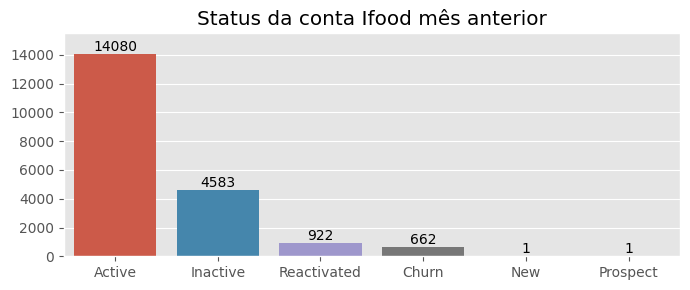

In [83]:
plt.figure(figsize=(7,3))

ax = sns.countplot(mkt, x='ifood_status_last_month', order=mkt['ifood_status_last_month'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.title('Status da conta Ifood mês anterior')
plt.ylim([0,15500])
plt.ylabel("")
plt.xlabel("")
plt.tight_layout()
plt.show()


### Quantidade de pedidos pelo status da conta atual

Text(0, 0.5, 'Total de pedidos')

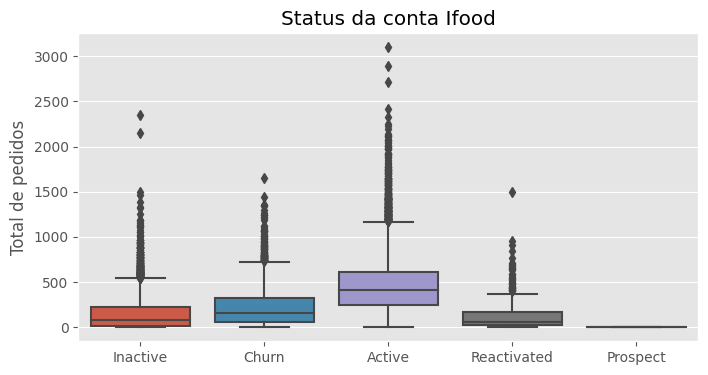

In [79]:
plt.figure(figsize=(8,4))

sns.boxplot(mkt, x='ifood_status', y = 'total_order_count')

plt.title('Status da conta Ifood')
plt.xlabel('')
plt.ylabel('Total de pedidos')

### Quantidade de pedidos pelo status da conta no mes anterior

Text(0.5, 0, '')

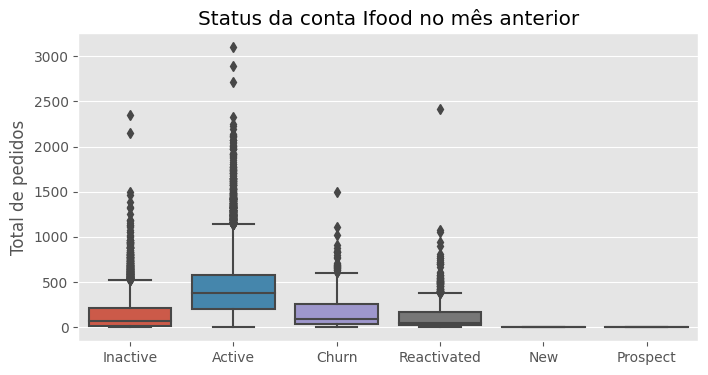

In [81]:
plt.figure(figsize=(8,4))

sns.boxplot(mkt, x='ifood_status_last_month', y = 'total_order_count')

plt.title('Status da conta Ifood no mês anterior')
plt.ylabel('Total de pedidos')
plt.xlabel('')

- É possível observar que as contas ativas tem um total de pedidos acima do que outros status de perfil, porém não são valores extremamente discrepantes. 

### Data de registro

Text(0.5, 0, 'Ano')

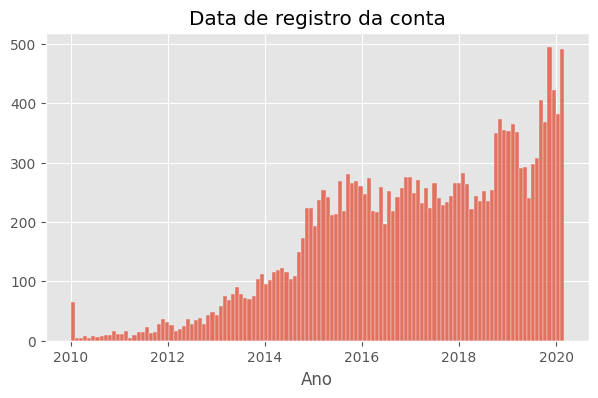

In [133]:
plt.figure(figsize=(7,4))

sns.histplot(mkt, x = 'registration_date', bins=120)
plt.ylabel("")
plt.title("Data de registro da conta")
plt.xlabel("Ano")

Na data de registro do cliente temos um aumento relevante nos anos mais recentes. Isso pode ter a ver com a popularização e acesso a aparelhos de smartphones mas no ano de 2020 tivemos o início da pandemia, contribuindo de maneira expressiva nesse aumento.

### Data primeiro pedido

Text(0.5, 0, 'Ano')

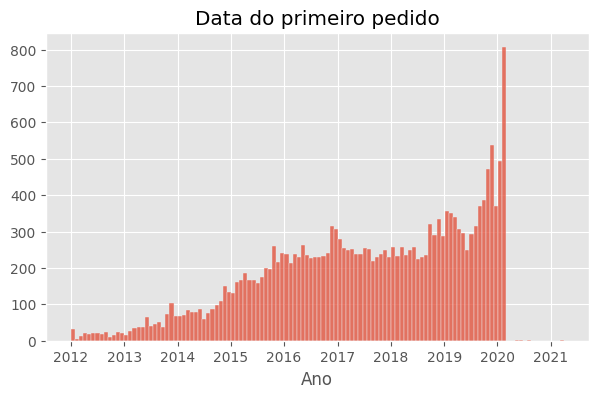

In [135]:
plt.figure(figsize=(7,4))

sns.histplot(mkt, x = 'first_order_date', bins=120)
plt.title("Data do primeiro pedido")
plt.ylabel("")
plt.xlabel("Ano")

## Sessões

In [159]:
sessoes.head(1)

,session_id,user_account_uuid,session_started,session_ended,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,tempo_sessao
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01 00:00:03.924000+00:00,2020-02-01 00:10:51.217000+00:00,19,5,6,6,7,5.00,462.00,0 days 00:10:47.293000


In [8]:
# Calculando tempo total de sessão
sessoes['tempo_sessao'] = (sessoes['session_ended'] - sessoes['session_started']).dt.total_seconds()

### Estatística descritiva

In [8]:
sessoes.iloc[:,4:11].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_view_restaurant_screen,3591511.00,6.54,12.91,0.00,0.00,2.00,8.00,2612.00
sum_view_dish_screen,3591511.00,3.40,6.02,0.00,0.00,1.00,4.00,635.00
sum_click_add_item,3591511.00,1.61,2.87,0.00,0.00,1.00,2.00,302.00
sum_view_checkout,3591511.00,2.02,4.23,0.00,0.00,1.00,3.00,422.00
sum_callback_purchase,3591511.00,0.74,2.10,0.00,0.00,0.00,1.00,681.00
load_time,2848111.00,39.95,1019.38,-75972.00,3.00,4.00,6.00,1120474.00
available_restaurants,3591511.00,1161.83,1121.17,0.00,324.00,831.00,1650.00,6149.00


## Pedidos

### Trabalhando as variáveis

#### Verificando categorias desbalanceadas

- Vamos investigar se as variáveis categóricas do nosso dataset estão desbalanceadas, pois se for o caso a variável não contribuirá para o modelo conseguir discriminar os clusters

In [9]:
def cat_desbalanceada(coluna, limiar = 80):
    """
    Verifica a proporção da categoria predominante na variável e caso esteja acima do limiar
    
    Args:
        coluna (str): Verifica a proporção da categoria predominante na variável e caso esteja acima do limiar estipulado
        limiar (int, optional): valor mínimo, em porcentagem. Padrão é 80.
    """
    
    percentual_cat1 = pedidos[coluna].value_counts().values[0]/len(pedidos[coluna])*100
    
    if percentual_cat1 > limiar:
        print(f'Categoria predominante na coluna {coluna}: {pedidos[coluna].value_counts().index[0]} | {round(percentual_cat1, 2)}% das observações')
    

In [10]:
for item in ['has_free_delivery', 'order_origin', 'device_platform', 'device_type']:
    cat_desbalanceada(item) 

Categoria predominante na coluna order_origin: RESTAURANT | 97.18% das observações
Categoria predominante na coluna device_type: MOBILE | 89.49% das observações


#### Valores monetários

A base de dados é  anonimizada, os valores com relação a pagamento estão em unidades monetárias. Para trabalharmos com valores mais palpaveis e consideramos que em centavos para facilitar a interpretação. 


- Tranformando os valores de centavos para reais
    * delivery_fee:	Taxa de entrega paga pelo cliente 'em reais'
    * total_amount:	Valor total pago pelo cliente 'em reais'
    * subsidy_amount: Subsídio, desconto dado no pedido ('em reais') - (para o valor final total do pedido: total_amount + subsidy)

In [11]:
pedidos[['delivery_fee','total_amount','subsidy_amount']] = pedidos[['delivery_fee','total_amount','subsidy_amount']].apply(lambda x: round(x/100,2))         
pedidos[['delivery_fee','total_amount','subsidy_amount']]

,delivery_fee,total_amount,subsidy_amount
0,8.75,53.75,0.00
1,0.00,29.88,12.50
2,0.00,37.38,21.24
3,8.62,22.38,0.01
4,0.00,27.50,0.00
...,...,...,...
226264,3.75,104.38,0.00
226265,8.74,63.49,0.00
226266,8.75,85.12,0.01
226267,0.00,35.00,8.74


#### Distância entre cliente e loja

In [12]:
# Calculando distancia entre cliente e loja
pedidos['distance'] = pedidos.apply(lambda row: haversine((row['customer_lat'], row['customer_long']),
                                                (row['merchant_lat'], row['merchant_long']),
                                                unit=Unit.KILOMETERS), axis=1)

#### Formatando datas

In [13]:
# Formatando para formato legivel
pedidos['confirmed_date_format'] = pedidos['confirmed_date'].dt.strftime('%d/%m/%Y %H:%M:%S')

pedidos['concluded_date_format'] = pedidos['concluded_date'].dt.strftime('%d/%m/%Y %H:%M:%S')

In [14]:
pedidos.drop(columns=['device_app_version', 'centroid_id', 'merchant_centroid_id', 
                      'merchant_zipcode', 'district', 'merchant_district', 'merchant_long',
                      'merchant_lat', 'customer_long', 'order_origin', 'device_type', 
                      'customer_lat'], axis=1, inplace=True)

### Datas

In [ ]:
pedidos[pedidos['confirmed_date'].isnull()][['confirmed_date_format','concluded_date_format']]

,confirmed_date_format,concluded_date_format
14218,NaN,18/02/2020 18:31:31
27814,NaN,18/02/2020 18:33:34
32263,NaN,18/02/2020 18:34:33
81774,NaN,18/02/2020 12:54:15
99762,NaN,18/02/2020 12:42:37
100774,NaN,18/02/2020 18:31:31
102572,NaN,18/02/2020 18:36:29
112282,NaN,18/02/2020 18:36:40
117261,NaN,18/02/2020 18:36:29
143533,NaN,18/02/2020 18:36:30


Ao verificarmos as datas ausentes de confirmação de pedido podemos ver que a data de conclusão ocorre no mesmo dia e em horários similares. Podemos inferir que uma oscilação no sistema ou erro possa ter causado esses resultados.

In [ ]:
pedidos[pedidos['concluded_date'].isnull()][['confirmed_date_format','concluded_date_format']]

,confirmed_date_format,concluded_date_format
133822,30/05/2020 10:50:53,NaN
144676,13/08/2020 08:34:31,NaN
187989,01/06/2020 08:55:51,NaN
201756,13/08/2020 08:24:25,NaN


Nesse caso temos poucas observações com dados proximos. Não necessariamente se enquadra no mesmo caso que o anterior porém é uma possibilidade.

In [ ]:
pedidos[pedidos['lag_last_order'].isnull()][['lag_last_order','confirmed_date_format','concluded_date_format']]

,lag_last_order,confirmed_date_format,concluded_date_format
99,NaN,02/02/2020 19:50:45,02/02/2020 21:14:57
1427,NaN,29/02/2020 22:03:02,29/02/2020 22:29:17
1854,NaN,14/02/2020 18:44:17,14/02/2020 19:17:53
3466,NaN,21/02/2020 20:14:39,21/02/2020 21:04:47
6942,NaN,29/02/2020 14:11:46,29/02/2020 15:34:34
...,...,...,...
219535,NaN,23/02/2020 03:07:55,23/02/2020 05:07:55
219740,NaN,22/02/2020 21:20:18,22/02/2020 23:04:52
222844,NaN,14/02/2020 15:24:55,14/02/2020 16:21:31
223901,NaN,01/02/2020 22:08:12,02/02/2020 00:08:23


Nesse caso também temos diferenças de horários porém todos os pedidos confirmados e concluidos são no mesmo dia.

Verificamos inicialmente a quantidade de valores nulos presentes no dataset, e encontramos valores abaixo de 1%. Assim vamos excluir os dados NaN.

In [15]:
pedidos.dropna(inplace=True)

### Distancia entre cliente e loja

,count,mean,std,min,10%,25%,50%,75%,98%,max
distance,226269.00,2.40,23.21,0.00,0.00,1.11,2.04,3.25,6.98,9313.52


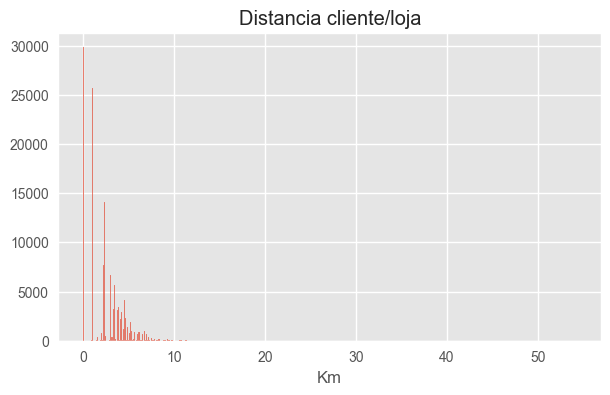

In [154]:
plt.figure(figsize=(7,4))

sns.histplot(pedidos[pedidos['distance'] < 60], x = 'distance')
plt.title('Distancia cliente/loja')
plt.xlabel('Km')
plt.ylabel("")

pedidos['distance'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.98]).to_frame().T

- A distancia entre clientes e lojas se concentram em até 10km
- Alguns valores aberrantes foram identificados

#### Averiguando observações com distancias muito acima

In [250]:
pedidos[pedidos['distance'] > 60].shape[0]

8

Não foi possível verificar a causa desses dados, mas temos somente 8 observações com essa característica.

### Tempo de conclusão do pedido

In [16]:
# Calculando
pedidos['tempo_total'] = (pedidos['concluded_date'] - pedidos['confirmed_date']).dt.total_seconds()
pedidos['tempo_total_orig'] = pedidos['concluded_date'] - pedidos['confirmed_date']

#### Descritiva

In [44]:
# Tempo acima de 8 horas
pedidos[pedidos['tempo_total_orig'] > '0 days 08:50:16.831500'].T

,225,495,557,681,711,826,880,949,1007,1137,...,224747,224765,224796,225008,225135,225237,225242,225284,225368,225884
order_id,31dd2746-8fd9-4268-aeaf-6c7938b28783,6f2954e1-9fcc-45ed-bcb3-afe6abcdccec,7e347403-3cbd-410e-b262-c757322d7615,9e2cbad6-c246-427f-9155-7d74dbfacda1,a61027d3-8551-4840-b74b-b408d1472450,bc3b33f4-d3af-4af8-afcf-7a702750620b,c66f6732-3fc8-4267-a436-81b45282764b,d9c4c1ad-3f25-45e0-a09f-cc202d79a5a2,e89b1e88-1434-4eed-95f3-727ba75cef31,073ab3e7-f87c-4377-b3a8-95fc484e717f,...,a03b9a5b-6852-4893-9dd4-bddaf6dcb143,a3ed8c63-e53a-4a42-ad3f-4accaa6c345c,aa5032e3-bf07-40eb-baa6-754a1ea2fd89,d5e91d16-4529-4552-a97e-f31bd8658a9e,f43d4b3b-832b-4718-ae59-f72b1b469843,0b84bc12-3934-426b-8d2a-7d82b028dddb,0c9ee441-b241-4e7b-90a1-d9c9666d163b,146698f9-7b0b-42a3-be87-7e5f4571471a,291c34bc-42e0-4802-b278-d354d38dcf68,a77378a4-8c09-4e1f-9f23-466dcaf99529
order_shift,weekday dinner,weekday lunch,weekday lunch,weekday lunch,weekday lunch,weekday lunch,weekday breakfast,weekday lunch,weekday lunch,weekday lunch,...,weekday breakfast,weekday breakfast,weekend breakfast,weekday lunch,weekday breakfast,weekday lunch,weekday lunch,weekday lunch,weekday snack,weekday breakfast
order_origin,STORE,RESTAURANT,QUICKLY_MEAL,QUICKLY_MEAL,RESTAURANT,QUICKLY_MEAL,RESTAURANT,RESTAURANT,RESTAURANT,RESTAURANT,...,STORE,RESTAURANT,STORE,STORE,RESTAURANT,RESTAURANT,RESTAURANT,RESTAURANT,STORE,RESTAURANT
delivery_fee,623.75,562.50,0.00,0.00,875.00,0.00,0.00,0.00,500.00,875.00,...,0.00,500.00,0.00,862.50,0.00,812.50,0.00,0.00,0.00,0.00
scheduled,True,False,True,True,False,True,False,False,False,False,...,True,False,True,True,False,False,False,False,True,False
total_amount,10923.75,2812.50,1623.75,1373.75,3737.50,1873.75,1250.00,4250.00,2737.50,2525.00,...,7137.50,2737.50,6051.25,10723.75,1250.00,3525.00,1300.00,2000.00,6843.75,20312.50
subsidy_amount,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.25,0.00,...,0.00,-1.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
device_platform,ANDROID,ANDROID,IOS,IOS,ANDROID,IOS,DESKTOP,ANDROID,ANDROID,IOS,...,ANDROID,ANDROID,ANDROID,IOS,DESKTOP,ANDROID,ANDROID,DESKTOP,ANDROID,ANDROID
device_type,MOBILE,MOBILE,MOBILE,MOBILE,MOBILE,MOBILE,SITE,MOBILE,MOBILE,MOBILE,...,MOBILE,MOBILE,MOBILE,MOBILE,SITE,MOBILE,MOBILE,SITE,MOBILE,MOBILE
device_app_version,9.59.0,9.37.1,9.43.1,9.34.0,9.36.0,9.58.0,NaN,9.48.1,9.36.0,9.37.1,...,9.46.1,9.36.0,9.48.0,9.42.0,NaN,9.36.0,9.36.0,NaN,9.51.1,9.37.1


Não foi possível identificar uma possível causa para os tempos de entrega tão aumentados.

In [17]:
# Selecionando tipos de variáveis
pedidos_num = pedidos.select_dtypes('number').columns
pedidos_cat = pedidos.select_dtypes('object').columns
pedidos_bool = pedidos.select_dtypes('boolean').columns

### Descritiva das variáveis numéricas

In [18]:
pedidos[pedidos_num].describe()

,delivery_fee,total_amount,subsidy_amount,lag_last_order,review_score,nps_score,distance,tempo_total,tempo_total_orig
count,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067.00,226067
mean,4.06,60.19,3.43,2.51,4.67,9.11,2.39,7947.02,0 days 02:12:27.019267602
std,5.04,51.82,6.77,11.99,0.93,1.90,22.77,11462.21,0 days 03:11:02.211207978
min,-12.48,0.00,-0.02,0.00,1.00,1.00,0.00,-14316.90,-1 days +20:01:23.097000
25%,0.00,27.74,0.00,0.00,5.00,9.00,1.11,2141.86,0 days 00:35:41.865000
50%,0.00,45.00,0.00,1.00,5.00,10.00,2.04,7199.31,0 days 01:59:59.308000
75%,7.49,75.31,6.24,2.00,5.00,10.00,3.25,14399.50,0 days 03:59:59.504000
max,50.00,1748.74,196.11,1429.00,5.00,10.00,9313.52,649721.08,7 days 12:28:41.080000


- Taxa de entrega:
    - Média R$ 4,06
    - Mediana R$ 0
    - Máximo R$ 50
    - 75% dos valores abaixo de R$ 8
    - Valor mínimo negativo (possível erro)<br>
<br>
- Valor da total da compra:
    - Média R$ 60,19
    - Mediana R$ 45
    - Máximo R$ 1.748,74
    - 75% dos valores abaixo de R$ 80<br>
<br>
- Ultima compra:
    - Média 2 dias
    - Mediana 1 dia
    - 75% dos valores até 2<br>
<br>
- Distancia cliente/loja:
    - Média e mediana próximas
    - Máximo extremamente alto
    - 75% dos valores abaixo de 3.5KM<br>
<br>
- Review score:
    - Média, mediana, 75% e máximo similares<br>
<br>
- NPS score:
    - Média proxima de 9
    - Mediana, 75% e máximo 10

#### Investigando valores negativos

In [ ]:
len(pedidos[pedidos['tempo_total'] < 0])

2

In [ ]:
len(pedidos[pedidos['delivery_fee'] < 0])

1

No geral a maioria dos clientes gasta menos de R$ 80 por compra, com taxa de entrega média de R$ 4.
A maioria dos clientes são recorrentes, média de 2 dias da ultima compra, e estão satisfeitos com o serviço e produtos com scores proximos do máximo.

### Descritiva variáveis categóricas

In [47]:
pedidos[['order_shift', 'device_platform', 'state_label', 'dish_type', 'has_free_delivery']].describe().T

,count,unique,top,freq
order_shift,226067,10,weekday lunch,58385
device_platform,226067,3,ANDROID,117973
state_label,226067,27,SP,129829
dish_type,226067,61,Lanches,44199
has_free_delivery,226067,2,True,119662


### Visualizações

#### Período do pedido

Text(0, 0.5, '')

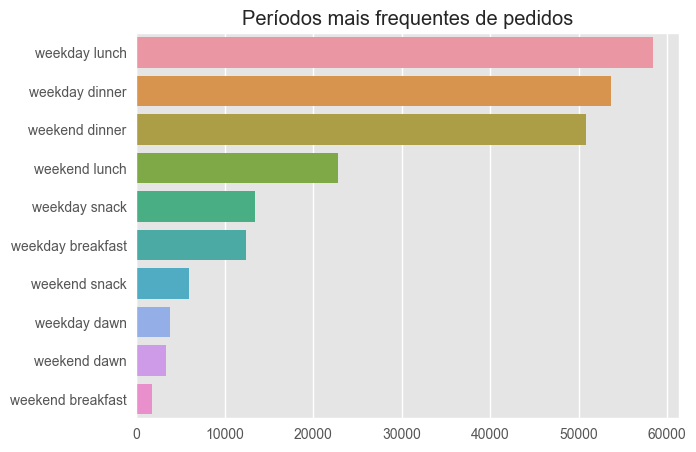

In [223]:
plt.figure(figsize=(7, 5))

plt.title('Períodos mais frequentes de pedidos')
sns.countplot(pedidos, y='order_shift', order=pedidos['order_shift'].value_counts().index)

plt.xlabel("")
plt.ylabel("")

- Os períodos que são mais requisitados refeições são os almoçoes e jantas de dias da semana. Podemos supor que são trabalhadores e/ou empresas com convênios oferecidos para essas refeições aos seus funcionários, seguidos de jantar no período de final de semana. 

#### Tipo de comida

Text(0, 0.5, '')

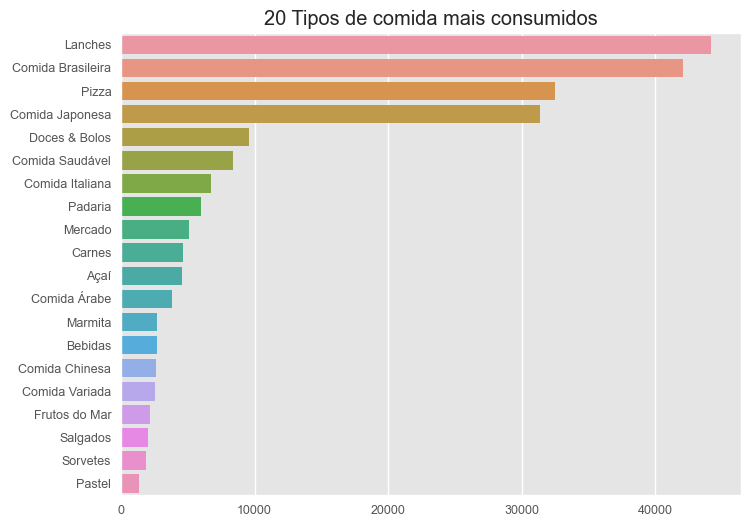

In [55]:
plt.figure(figsize=(8, 6))

plt.title('20 Tipos de comida mais consumidos')
ax = sns.countplot(pedidos, y='dish_type', order=pedidos['dish_type'].value_counts().head(20).index)

ax.tick_params(labelsize=9)

plt.xlabel("")
plt.ylabel("")

Text(0, 0.5, '')

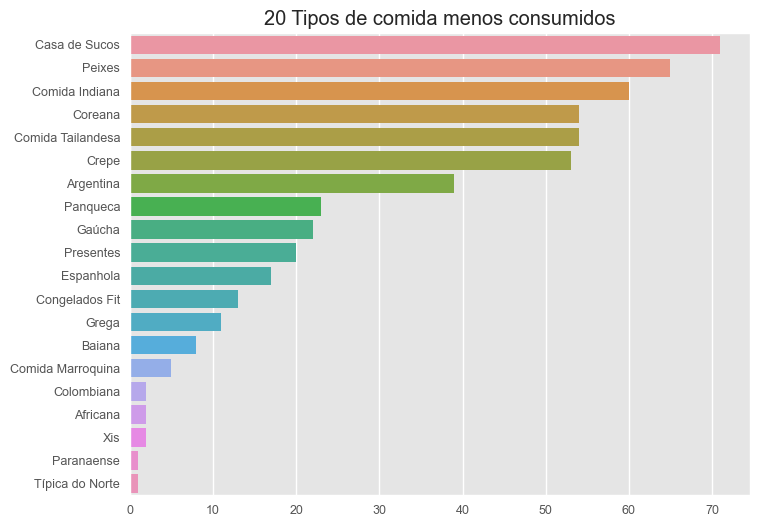

In [56]:
plt.figure(figsize=(8, 6))

plt.title('20 Tipos de comida menos consumidos')
ax = sns.countplot(pedidos, y='dish_type', order=pedidos['dish_type'].value_counts().tail(20).index)

ax.tick_params(labelsize=9)

plt.xlabel("")
plt.ylabel("")

#### Estados com mais pedidos

Text(0.5, 0, '')

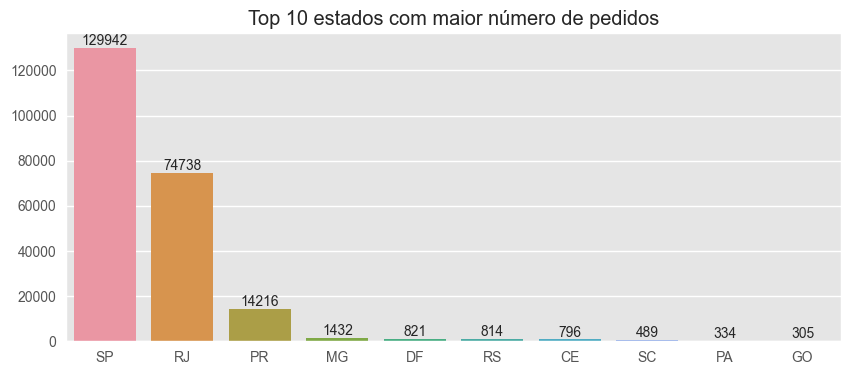

In [220]:
plt.figure(figsize=(10,4))

ax = sns.countplot(pedidos, x='state_label', order=pedidos['state_label'].value_counts().head(10).index)
ax.bar_label(ax.containers[0])
plt.title('Top 10 estados com maior número de pedidos')
plt.ylabel("")
plt.xlabel("")

- Os pedidos se concentram nos estados de São Paulo, Rio de Janeiro e Paraná.

#### Cidades com mais pedidos (Por estados com mais pedidos)

In [242]:
def top_cidades(estado):
    """
    Gráfico de barra expondo top 5 cidades com mais compras no estado escolhido

    Args:
        estado (str): string com a sigla do estado
    """
    plt.figure(figsize=(8,3))

    ax = sns.countplot(pedidos[pedidos['state_label'] == estado], x='city', order=pedidos[pedidos['state_label'] == estado]['city'].value_counts().head(5).index)
    ax.bar_label(ax.containers[0])
    plt.title(f'Estado de {estado.upper()}: Top 5 cidades em vendas ')
    plt.xticks(rotation=45)
    plt.ylim([0, int(pedidos[pedidos['state_label'] == estado]['city'].value_counts().values[0] + 10000)])
    
    plt.ylabel("")
    plt.xlabel("")

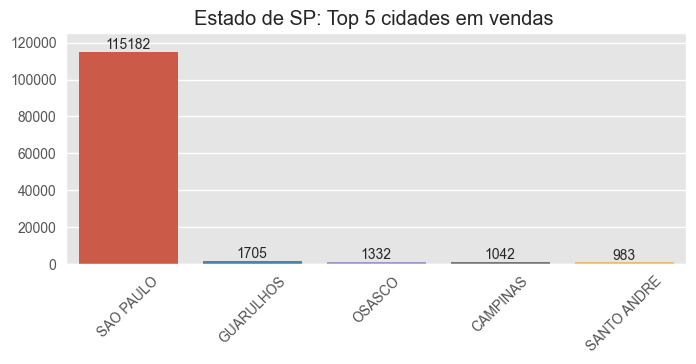

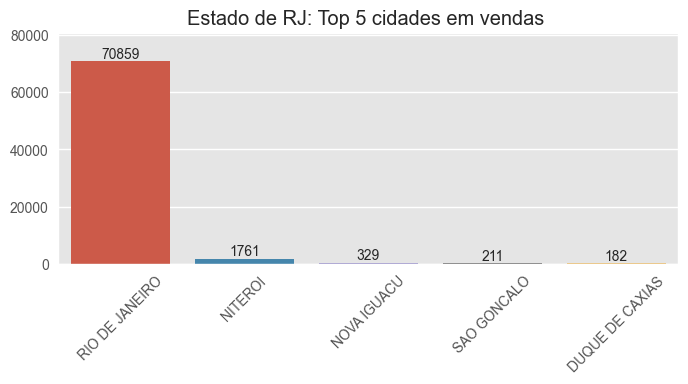

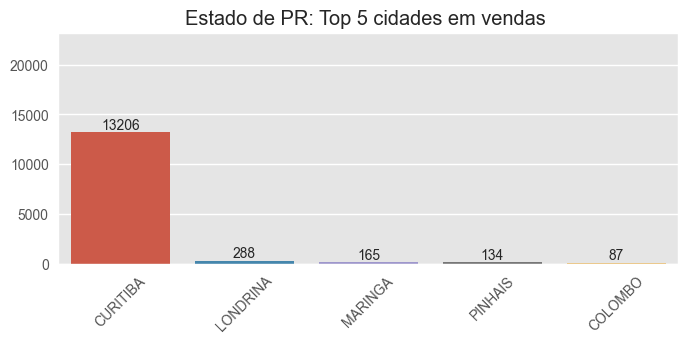

In [243]:
for item in ['SP', 'RJ', 'PR']:
    top_cidades(item)

#### Plataforma usada

Text(0.5, 0, '')

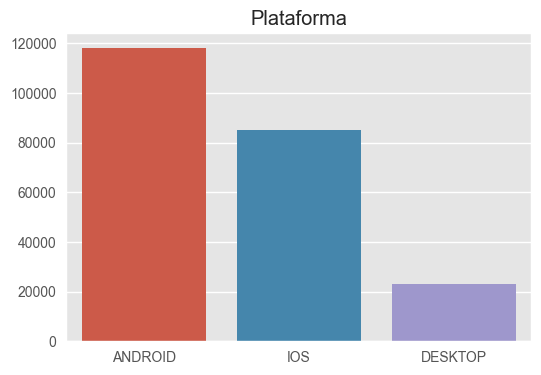

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(pedidos, x='device_platform', order=pedidos['device_platform'].value_counts().index)
plt.title('Plataforma')
plt.ylabel("")
plt.xlabel("")

#### Tipo de entrega

Text(0.5, 0, '')

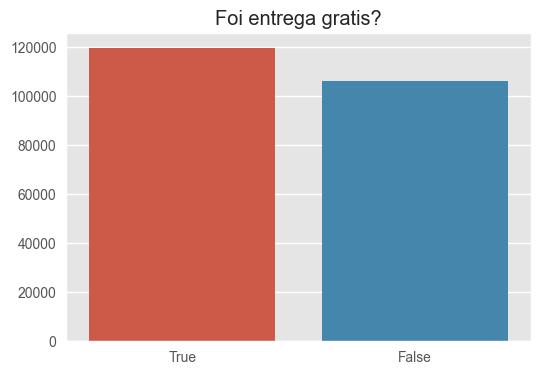

In [ ]:
plt.figure(figsize=(6,4))

ax = sns.countplot(pedidos, x='has_free_delivery', order=pedidos['has_free_delivery'].value_counts().index)
plt.title('Foi entrega gratis?')
plt.ylabel("")
plt.xlabel("")

#### Quantidade de pedidos

In [10]:
df_qnt_pedidos = pedidos.groupby('account_id')['order_id'].nunique().to_frame()
df_qnt_pedidos.reset_index(inplace=True)
df_qnt_pedidos.columns = ['id_conta', 'qnt_pedidos']

Text(0.5, 0, 'Numero de pedidos')

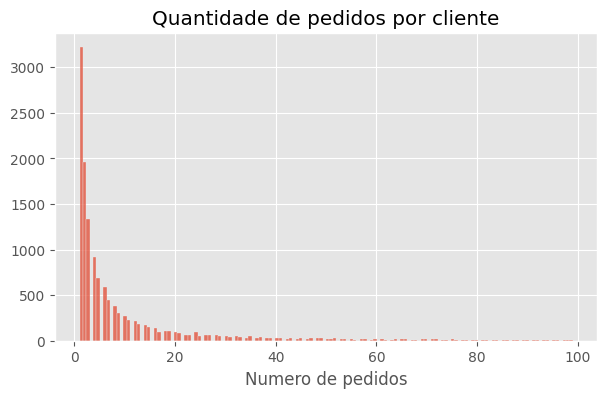

In [38]:
plt.figure(figsize=(7,4))

sns.histplot(df_qnt_pedidos[df_qnt_pedidos['qnt_pedidos'] < 100], x = 'qnt_pedidos')

df_qnt_pedidos['qnt_pedidos'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.99])
plt.title('Quantidade de pedidos por cliente')
plt.ylabel("")
plt.xlabel("Numero de pedidos")

### Avaliando presença de outliers

- Isolation Forest 
    - Técnica de detecção de outliers que identifica anomalias em vez de observações normais
    - Assim como Random Forest, ele é construído sobre um conjunto de árvores binárias (isolamento)
    - Pode lidar com conjuntos de dados grandes e de alta dimensão
    - Pontuação de -1 é atribuída a anomalias e 1 a pontos normais. 

In [59]:
pedidos.select_dtypes(include= 'number').columns

Index(['delivery_fee', 'total_amount', 'subsidy_amount', 'lag_last_order',
       'review_score', 'nps_score', 'distance', 'tempo_total',
       'tempo_total_orig'],
      dtype='object')

In [60]:
from sklearn.ensemble import IsolationForest

data = pedidos[['delivery_fee', 'total_amount', 'subsidy_amount', 
                'lag_last_order', 'review_score', 'nps_score', 
                'distance', 'tempo_total']]

# training the model
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(data)

# predictions
outlier_Scores = clf.decision_function(data)
outlier_df = pd.concat([data,pd.Series(outlier_Scores, name="outlier_Scores")], axis=1)
outlier_df.sort_values(by='outlier_Scores', ascending=True).dropna()

,delivery_fee,total_amount,subsidy_amount,lag_last_order,review_score,nps_score,distance,tempo_total,outlier_Scores
107675,0.00,148.74,16.24,1.00,5.00,10.00,6.34,2584.40,-0.24
2999,0.00,106.00,0.00,3.00,5.00,10.00,0.00,14400.04,-0.24
59144,0.00,26.12,0.00,3.00,5.00,10.00,1.11,1217.51,-0.23
166543,0.00,16.24,0.00,1.00,1.00,1.00,1.11,8994.05,-0.23
79530,5.00,24.09,0.00,0.00,5.00,10.00,1.51,7199.89,-0.23
...,...,...,...,...,...,...,...,...,...
63928,10.00,23.12,0.00,0.00,5.00,10.00,0.00,7200.34,0.16
119359,3.75,35.00,0.00,1.00,5.00,8.00,1.11,4971.01,0.16
139873,0.00,20.88,16.25,0.00,5.00,10.00,1.02,4356.41,0.16
194852,6.25,93.62,0.00,2.00,5.00,10.00,6.35,14400.10,0.16


Text(0, 0.5, '')

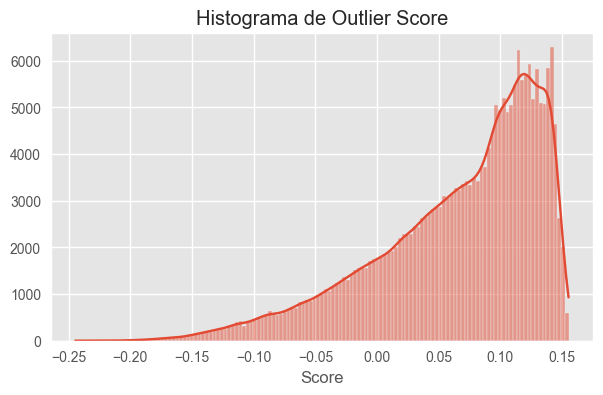

In [66]:
plt.figure(figsize=(7,4))
plt.title('Histograma de Outlier Score')
sns.histplot(data=outlier_df, x = "outlier_Scores", kde=True)
plt.xlabel('Score')
plt.ylabel('')

### Avaliando correlação entre variáveis

#### Numéricas

<Axes: title={'center': 'Mapa de calor de correlação entre variáveis numéricas'}>

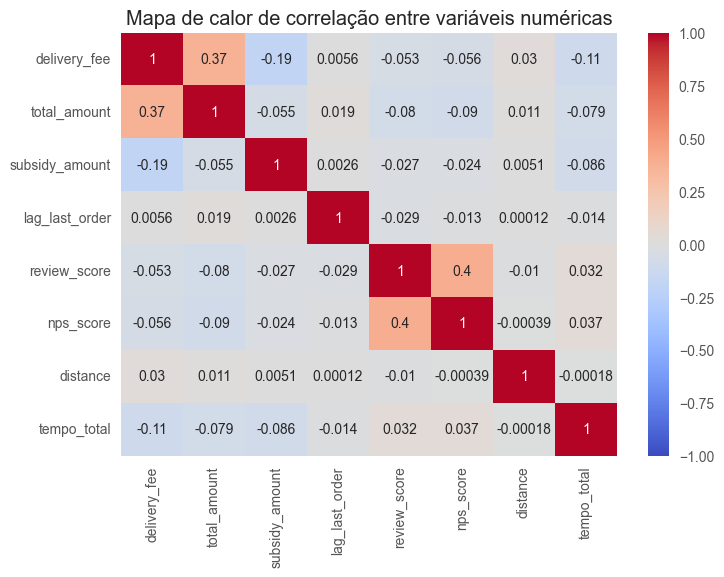

In [68]:
plt.title('Mapa de calor de correlação entre variáveis numéricas')
sns.heatmap(data.corr(method='pearson'), annot=True, vmin=-1, vmax=1,cmap='coolwarm')

#### Categóricas

- V de Cramér (ou phi de Cramér) 
    - Medida de associação entre duas variáveis nominais
    - Valor varia de 0 a 1, em que 0 indica nenhuma associação e 1 indica uma associação perfeita



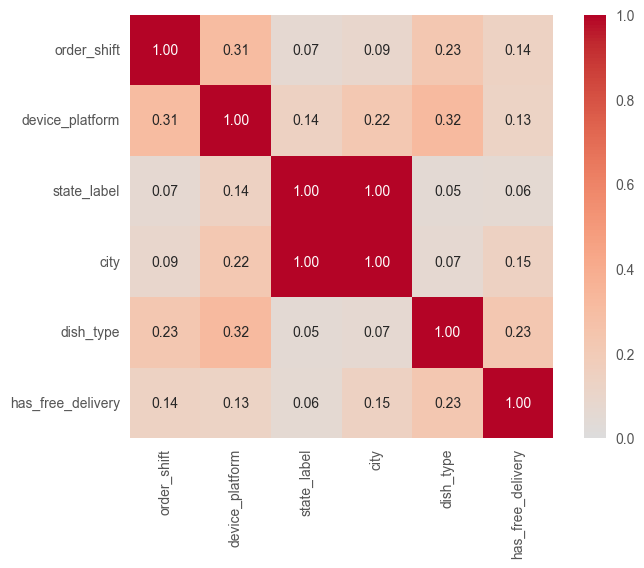

In [79]:
data2 = pedidos[['order_shift', 'device_platform', 'state_label', 'city', 'dish_type', 'has_free_delivery']]

# Estime e gere o gráfico de associação V de Cramer 
cramers_v =associations(data2, 
             nom_nom_assoc = 'cramer',
             cmap = "coolwarm")

Não encontramos nenhuma associação relevante e que pudesse influenciar nos modelos.

# 4.Seleção e Feature engeneering

- Nesse problema temos informações relevantes em diferentes datasets, e também não temos uma relação de 1 para 1 (no caso temos multiplos clientes realizando multiplos pedidos gerando multiplas variáveis que podem ou não ser usadas como metricas - média, mediana, moda, etc.)

## Análise RFM

- Acrônimo para Recency (Recência), Frequency(Frequência) e Monetary (valor monetário)
    * Recência: há quanto tempo o cliente fez uma transação (data maxima de compra - ultima data de compra) 
    * Frequência: Com que frequência o cliente encomenda/compra algum produto nosso (no caso total de compras)
    * Monetário: Quanto o cliente gasta comprando nossos produtos (Valor total/médio/mediano do quanto ele gasta)<br>
    <br>
- Forma de segmentação da sua base de clientes com base em quão engajados com o seu negócio eles estão<br>
<br>
- Conceito usado para segmentar os diferentes perfiis de clientes, como: 
    - alto valor, médio valor ou baixo valor e outras possibilidades

In [81]:
df_recency  = pedidos.groupby(by='account_id',as_index=False) \
                                       .agg(concluded_date=('concluded_date', 'max'),
                                            Monetary_value_sum=('total_amount', 'sum'),
                                            Monetary_value_mean=('total_amount', 'mean'),
                                            Monetary_value_median=('total_amount', 'median'),
                                            delivery_fee_sum=('delivery_fee', 'sum'),
                                            subsidy_amount_sum=('subsidy_amount', 'sum'),
                                            Frequency = ('concluded_date', 'size'),
                                            order_shift = ('order_shift',lambda x: x.value_counts().index[0]),
                                            device_platform = ('device_platform',lambda x: x.value_counts().index[0]),
                                            state_label = ('state_label',lambda x: x.value_counts().index[0]),
                                            city = ('city',lambda x: x.value_counts().index[0]),
                                            dish_type = ('dish_type',lambda x: x.value_counts().index[0]),
                                            has_free_delivery = ('has_free_delivery',lambda x: x.value_counts().index[0]))

In [84]:
recent_date = df_recency['concluded_date'].max() # recent_date = data mais recente do banco de dados
df_recency['Recency'] = df_recency['concluded_date'].apply( lambda x: (recent_date - x).days)

In [85]:
df_recency.head()

,account_id,concluded_date,Monetary_value_sum,Monetary_value_mean,Monetary_value_median,delivery_fee_sum,subsidy_amount_sum,Frequency,order_shift,device_platform,state_label,city,dish_type,has_free_delivery,Recency
0,00073adf-7117-44ba-90fe-5879c9581b68,2020-02-07 12:44:00.625000+00:00,27.38,27.38,27.38,0.00,0.00,1,weekday lunch,ANDROID,PR,CURITIBA,Marmita,True,236
1,000b1fec-8616-4014-9581-c5a944911ac3,2020-08-19 22:10:44.806000+00:00,186.71,46.68,53.68,14.98,0.00,4,weekday dinner,ANDROID,RJ,RIO DE JANEIRO,Lanches,False,42
2,000db136-b110-4dd6-9d1c-a70ab1ab2d75,2020-09-28 14:12:51.488000+00:00,1053.23,40.51,38.37,62.48,111.17,26,weekday dinner,ANDROID,SP,SAO PAULO,Lanches,True,2
3,000f5a0c-cfac-44f9-a296-7f745b38a863,2020-09-26 14:17:44.114000+00:00,703.43,63.95,57.49,83.67,0.01,11,weekday lunch,IOS,SP,SAO PAULO,Mercado,False,4
4,0019a335-0326-4032-af5b-7b76413633e0,2020-09-07 21:57:39.474000+00:00,348.54,174.27,174.27,13.73,0.00,2,weekday dinner,ANDROID,SP,SAO PAULO,Comida Contemporânea,False,23


## Agregando dados do dataframe mkt

In [86]:
mkt['TempoVida'] = (pd.to_datetime(recent_date.strftime("%Y-%m-%d")) - pd.to_datetime(mkt['first_order_date'])).dt.days 
mkt.head()

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date,TempoVida
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28,216.00
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19,1292.00
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02,760.00
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01,884.00
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12,416.00


In [87]:
df_final = df_recency.merge(mkt[['account_id','TempoVida','first_order_date','total_order_count']], how='inner')
df_final.head()

,account_id,concluded_date,Monetary_value_sum,Monetary_value_mean,Monetary_value_median,delivery_fee_sum,subsidy_amount_sum,Frequency,order_shift,device_platform,state_label,city,dish_type,has_free_delivery,Recency,TempoVida,first_order_date,total_order_count
0,00073adf-7117-44ba-90fe-5879c9581b68,2020-02-07 12:44:00.625000+00:00,27.38,27.38,27.38,0.00,0.00,1,weekday lunch,ANDROID,PR,CURITIBA,Marmita,True,236,434.00,2019-07-25,270
1,000b1fec-8616-4014-9581-c5a944911ac3,2020-08-19 22:10:44.806000+00:00,186.71,46.68,53.68,14.98,0.00,4,weekday dinner,ANDROID,RJ,RIO DE JANEIRO,Lanches,False,42,2248.00,2014-08-06,791
2,000db136-b110-4dd6-9d1c-a70ab1ab2d75,2020-09-28 14:12:51.488000+00:00,1053.23,40.51,38.37,62.48,111.17,26,weekday dinner,ANDROID,SP,SAO PAULO,Lanches,True,2,1331.00,2017-02-08,573
3,000f5a0c-cfac-44f9-a296-7f745b38a863,2020-09-26 14:17:44.114000+00:00,703.43,63.95,57.49,83.67,0.01,11,weekday lunch,IOS,SP,SAO PAULO,Mercado,False,4,2397.00,2014-03-10,653
4,0019a335-0326-4032-af5b-7b76413633e0,2020-09-07 21:57:39.474000+00:00,348.54,174.27,174.27,13.73,0.00,2,weekday dinner,ANDROID,SP,SAO PAULO,Comida Contemporânea,False,23,2282.00,2014-07-03,652


In [89]:
dados_ausentes(df_final, 'dataframe final')

COLUNAS DO DATASET DATAFRAME FINAL COM VALORES NaN:


,Coluna,Tipo,Contagem,%


In [90]:
df_final.to_csv('data/df_final.csv', index_label=False)

In [3]:
df = pd.read_csv('data/df_final.csv')

## Dicionário de Dados 

* **account_id:** Identificador do cliente 
* **concluded_date:** Data de conclusão do último pedido solicitado
* **Monetary_value_sum:** Valor total pago pelo cliente 
* **Monetary_value_mean:** Valor médio pago pelo cliente
* **Monetary_value_median:** Valor mediano pago pelo cliente
* **delivery_fee_sum:** Valor total de taxa de entrega pago pelo cliente 
* **subsidy_amount_sum:** Valor total de desconto recebido pelo cliente 
* **Frequency:** Quantos pedidos foram concluídos no período
* **order_shift:**  Período em que o pedido foi feito 
* **device_platform:** Plataforma (sistema operacional) utilizado para fazer o pedido (ANDROID, DESKTOP, etc)
* **state_label:** Sigla da UF do cliente
* **city:** Cidade do cliente
* **dish_type:** Tipo de cozinha:  Classificação do tipo de comida solicitado (Marmita, lanches, ...)
* **has_free_delivery:** Booleano que indica se o pedido foi entrega grátis
* **Recency:** Há quanto tempo o cliente fez o ultimo pedido conosco 
* **first_order_date:** Data do primeiro pedido 
* **total_order_count:** Total de pedidos feito pelo cliente
* **TempoVida:** Ultima data do banco - first order date 

# 5.Pré-Processamento

- Variáveis de maiores magnitudes podem afetar o modelo de maneira mais intensa, por isso devemos utilizar alguma padronização/transformação para termos todos os dados em uma escala similar.<br>
<br>
- Algumas das técnicas mais comuns são:
    - MinMaxScaler: transforma em valores entre 0 e 1. É altamente influenciado por valores minimo e máximo (problemas com outliers)
    - StandardScale: centraliza os dados  en torno  de 0 com desvio padrão 1. Menos afetado por outliers 
    - RobustScaler: utiliza mediana e intervalos interquartil para transformação. Util para situações com outliers

In [5]:
cols_num_kmeans = df.select_dtypes('number').columns

df_kmeans = df[cols_num_kmeans]

In [7]:
processador_num_kmeans = Pipeline([
    ('scaler', RobustScaler())
])

processador_kmeans = ColumnTransformer(transformers = [
    ('processamento_numericas', processador_num_kmeans, cols_num_kmeans)
], remainder = 'passthrough', verbose_feature_names_out = False)

df_kmeans_robust = pd.DataFrame(processador_kmeans.fit_transform(df_kmeans), 
                                columns = processador_kmeans.get_feature_names_out())

In [16]:
df_kmeans_robust.head()

,Monetary_value_sum,Monetary_value_mean,Monetary_value_median,delivery_fee_sum,subsidy_amount_sum,Frequency,Recency,TempoVida,total_order_count
0,-0.34,-0.70,-0.62,-0.37,-0.26,-0.30,1.61,-0.68,-0.17
1,-0.11,-0.28,-0.03,-0.03,-0.26,0.00,-0.10,1.00,1.16
2,1.12,-0.41,-0.37,1.06,3.04,2.20,-0.45,0.15,0.60
3,0.62,0.10,0.06,1.54,-0.26,0.70,-0.43,1.14,0.81
4,0.12,2.52,2.67,-0.06,-0.26,-0.20,-0.26,1.03,0.81


# 6.Modelagem

## K-means

In [16]:
# Selecionando variáveis
df_kmeans = df_kmeans_robust[['Monetary_value_sum', 'Frequency', 'Recency']]

### Verificando número ideal de clusters

#### Método do cotovelo

In [17]:
def cotovelo(comeco, fim, df):
    no_of_clusters = list(range(comeco, fim+1))
    cost_values = []
    
    for k in no_of_clusters:
        kmeans = KMeans(n_clusters=k,init='k-means++',n_init = 10, max_iter=300)
        kmeans.fit(df)
        cost_values.append(kmeans.inertia_)
               
    plt.figure(figsize=(10, 4))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No de clusters', fontsize=14)
    ax.set_ylabel('Custo', fontsize=14)
    ax.set(xlim=(comeco-0.1, fim+0.1))
    plt.plot()

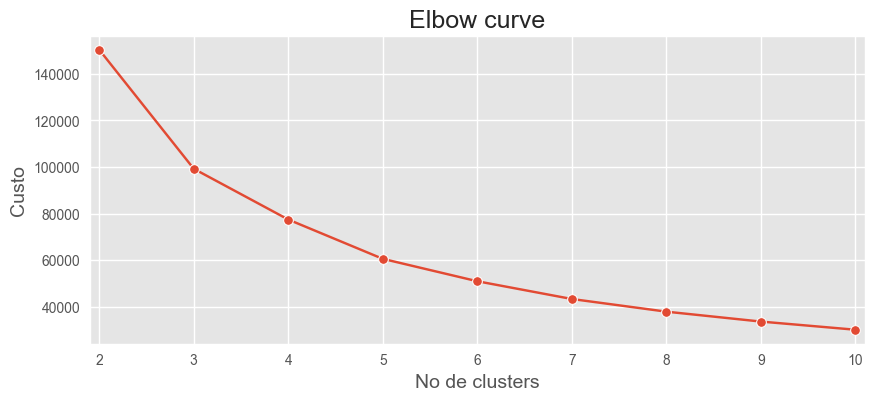

In [18]:
cotovelo(2, 10, df_kmeans)

#### Silhueta

In [19]:
def silhueta(comeco, fim, df):    
    kmeans = KMeans(random_state=123,init='k-means++',n_init = 10, max_iter=300)
    
    visualizer = KElbowVisualizer(kmeans, k=(comeco, fim), metric = 'silhouette', timings = False)
    visualizer.fit(df)
    visualizer.show()

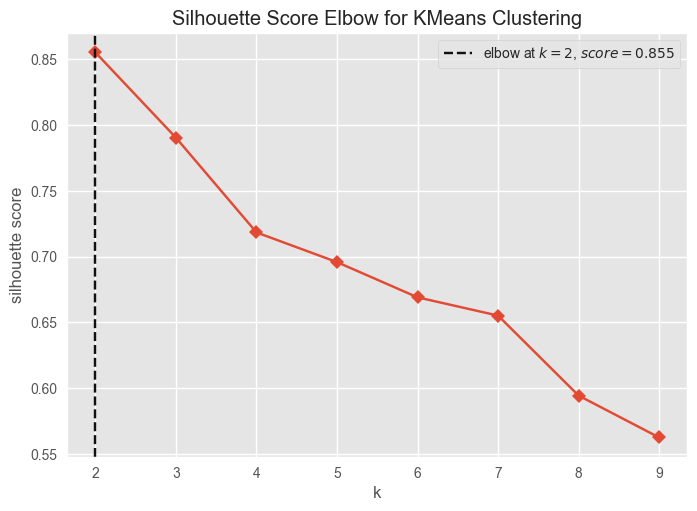

In [20]:
silhueta(2, 10, df_kmeans)

### Visualização

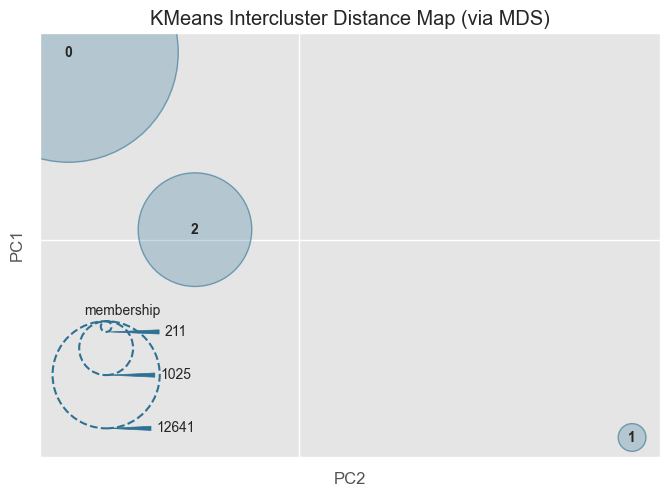

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [24]:
kmeans_3clusters = KMeans(3, init = 'k-means++', n_init = 'auto', max_iter=300, random_state=42)
visualizer = InterclusterDistance(kmeans_3clusters)

visualizer.fit(df_kmeans)       
visualizer.show()

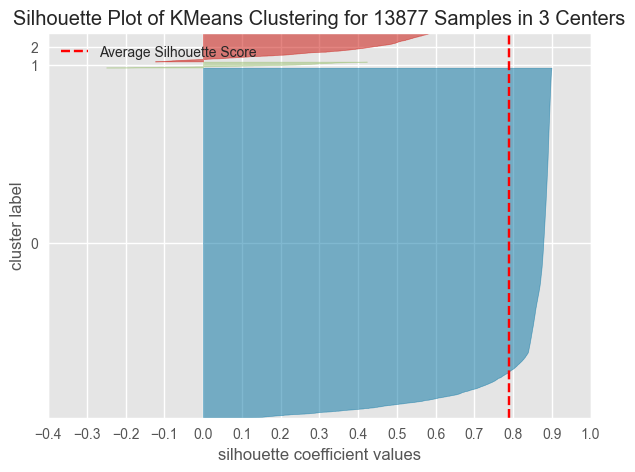

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 13877 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [25]:
visualizer = SilhouetteVisualizer(kmeans_3clusters, colors='yellowbrick')

plt.figure(figsize=(7,5))
visualizer.fit(df_kmeans)        # Fit the data to the visualizer
visualizer.show() 

### Métricas

In [26]:
kmeans_3clusters = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans_3clusters.fit(df_kmeans)

KMeans(n_clusters=3, n_init='auto', random_state=42)

In [27]:
inercia_total = kmeans_3clusters.inertia_
silhouette_total = silhouette_score(df_kmeans, kmeans_3clusters.labels_)

In [28]:
print('='*20)
print(f"Kmeans: 3 Cluters")
print('-'*20)
print(f"Inercia: {inercia_total:.2f}")
print(f"Silhueta: {silhouette_total:.2f}")
print('='*20)

Kmeans: 3 Cluters
--------------------
Inercia: 99270.99
Silhueta: 0.79


### Ajuste do modelo

In [29]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', n_init = 10, max_iter = 100, random_state = 42)
kmeans.fit_predict(df_kmeans)

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
df['kmeans_3clusters'] = kmeans.labels_

### Verificando características dos clusters

#### Variáveis numéricas

In [31]:
for item in df.select_dtypes('number').columns[:-1]:
    print(item)
    display(df.groupby('kmeans_3clusters')[item].describe().T)

Monetary_value_sum


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,462.45,13120.43,4867.45
std,593.36,7327.75,2410.43
min,0.37,1076.84,226.18
25%,91.23,8761.09,3177.52
50%,225.60,12596.25,4267.07
75%,569.47,15894.31,6089.19
max,4621.00,54561.28,14378.54


Monetary_value_mean


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,71.28,66.14,66.82
std,48.62,42.78,39.74
min,0.03,2.40,2.83
25%,40.81,27.88,40.03
50%,59.38,56.64,58.36
75%,86.24,96.30,84.80
max,1050.11,202.08,513.59


Monetary_value_median


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,67.81,59.46,59.37
std,48.09,38.53,35.83
min,0.04,0.12,0.12
25%,37.94,24.88,34.95
50%,55.59,50.62,52.25
75%,82.50,85.25,75.05
max,1050.11,194.37,314.37


delivery_fee_sum


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,31.35,877.09,326.98
std,46.79,684.06,248.79
min,0.00,0.00,0.00
25%,4.99,424.30,147.49
50%,14.98,848.91,279.19
75%,37.44,1191.97,463.73
max,508.75,4001.77,1322.40


subsidy_amount_sum


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,25.44,659.94,306.73
std,57.47,987.65,437.44
min,-0.13,-0.34,-0.11
25%,0.00,7.53,44.93
50%,6.25,353.32,151.88
75%,25.00,858.22,369.60
max,1246.50,6006.91,4276.27


Frequency


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,7.15,240.37,82.80
std,9.12,112.77,35.53
min,1.00,93.00,21.00
25%,1.00,168.50,56.00
50%,3.00,206.00,75.00
75%,9.00,274.00,105.00
max,64.00,834.00,237.00


Recency


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,84.46,5.13,20.86
std,72.82,19.04,40.26
min,0.00,0.00,0.00
25%,21.00,0.00,1.00
50%,62.00,0.00,4.00
75%,138.00,2.00,20.00
max,242.00,177.00,231.00


TempoVida


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,1223.08,1130.22,1197.82
std,676.65,749.55,688.39
min,215.00,238.00,239.00
25%,640.00,433.00,612.50
50%,1179.00,898.00,1111.50
75%,1710.00,1732.50,1677.50
max,3196.00,3002.00,3175.00


total_order_count


kmeans_3clusters,0,1,2
count,12640.00,211.00,1026.00
mean,368.43,776.02,490.41
std,300.34,339.28,269.94
min,2.00,147.00,72.00
25%,130.00,544.50,307.00
50%,318.00,690.00,436.00
75%,519.00,911.50,614.00
max,3098.00,2418.00,2108.00


In [32]:
contagem_kmeans_3clusters = pd.concat([df['kmeans_3clusters'].value_counts().to_frame().T, 
                                       pd.DataFrame(df['kmeans_3clusters'].value_counts()/df.shape[0]).T]).T

contagem_kmeans_3clusters.columns = ['contagem', '%']

In [33]:
df.groupby('kmeans_3clusters')[['Monetary_value_sum', 'delivery_fee_sum',
                                'subsidy_amount_sum', 'Frequency', 'Recency',
                                'TempoVida', 'total_order_count']].mean().T

kmeans_3clusters,0,1,2
Monetary_value_sum,462.45,13120.43,4867.45
delivery_fee_sum,31.35,877.09,326.98
subsidy_amount_sum,25.44,659.94,306.73
Frequency,7.15,240.37,82.80
Recency,84.46,5.13,20.86
TempoVida,1223.08,1130.22,1197.82
total_order_count,368.43,776.02,490.41


In [34]:
contagem_kmeans_3clusters.T

kmeans_3clusters,0,2,1
contagem,12640.00,1026.00,211.00
%,0.91,0.07,0.02


#### Variáveis categóricas

In [ ]:
var_cat_kmeans = df.select_dtypes(exclude = 'number').columns[[2, 3, 6, 7]]

In [ ]:
df.groupby('kmeans_3clusters')[var_cat_kmeans].describe().T

kmeans_3clusters                       0                  1              2
order_shift       count            12640                211           1026
                  unique              10                  7              8
                  top     weekend dinner      weekday lunch  weekday lunch
                  freq              3765                116            382
device_platform   count            12640                211           1026
                  unique               3                  3              3
                  top            ANDROID            ANDROID        ANDROID
                  freq              6704                 89            542
dish_type         count            12640                211           1026
                  unique              56                 15             27
                  top            Lanches  Comida Brasileira        Lanches
                  freq              3767                 61            317
has_free_delivery count            12640                211           1026
                  unique               2                  2              2
                  top              False               True          False
                  freq              7031                116            554

#### Insights do modelo

- __Cluster 0 - Clientes de baixo valor__
    - 12.640 clientes (91%)
    - Menor valor pago, média de R$ 462
    - Menor frequencia de pedidos, média de 7 no período
    - Recencia acima de 84 dias em média
    - A janta no final de semana é o período com mais pedido
    - Lanche é o prato mais pedido

- __CLuster 1 - Clientes de alto valor__
    - 211 clientes (2%)
    - Maior valor pago, média de R$ 13.120
    - Maior frequencia de pedidos, média de 240 pedidos no período
    - Recencia de 5 dias em média
    - O almoço durante em dias úteis é o prato mais pedido
    - Comida brasileira é o prato mais pedido

- __Cluster 2 - Clientes de médio valor__
    - 1026 clientes (7%)
    - Média de valor pago R$ 4867
    - Média de frequencia de pedidos 82
    - Recencia de 20 dias em média
    - O almoço durante em dias úteis é o prato mais pedido
    - Lanche é o prato mais pedido

____

## Kprototypes

In [37]:
df_kprototypes = df[['order_shift', 'device_platform', 'state_label', 
                    'dish_type', 'has_free_delivery', 'Frequency',
                    'Recency','Monetary_value_sum']]

### Verificando número ideal de clusters

In [39]:
categoricas = [df_kprototypes.columns.get_loc(c) for c in df_kprototypes.select_dtypes(exclude= 'number')] 

In [40]:
def kprototypes(start, end, data,categorical_index):
    no_of_clusters = list(range(start, end+1))
    cost_values = []
    
    for k in no_of_clusters:
        test_model = KPrototypes(n_clusters=k, init='Cao', random_state=42)
        test_model.fit_predict(data, categorical=categorical_index)
        cost_values.append(test_model.cost_)        
    plt.figure(figsize=(10, 4))
    ax = sns.lineplot(x=no_of_clusters, y=cost_values, marker="o", dashes=False)
    ax.set_title('Elbow curve', fontsize=18)
    ax.set_xlabel('No de clusters', fontsize=14)
    ax.set_ylabel('Custo', fontsize=14)
    ax.set(xlim=(start-0.1, end+0.1))
    plt.plot()

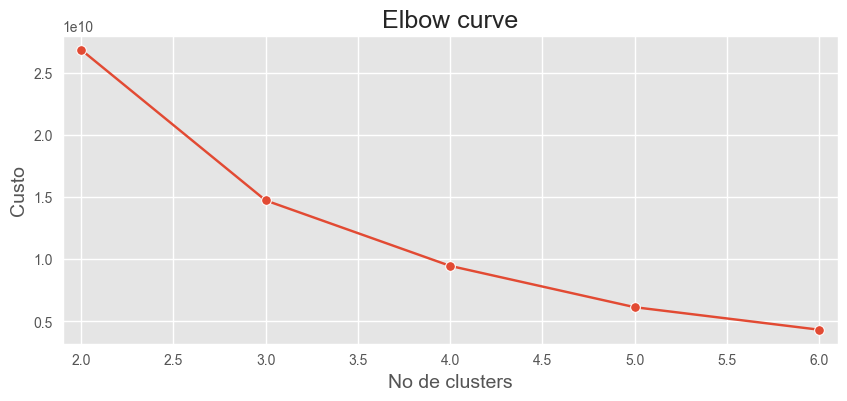

In [124]:
kprototypes(2, 6, df_kprototypes, categoricas)

### Métricas

### Ajuste do modelo

In [41]:
k_prototypes = KPrototypes(n_clusters = 3, init='Cao', n_jobs=-1, max_iter=300)
k_prototypes.fit_predict(df_kprototypes, categorical= categoricas)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint16)

In [42]:
df['kprototypes_3clusters'] = k_prototypes.labels_

In [43]:
df['kprototypes_3clusters'].value_counts()

kprototypes_3clusters
1    12639
2     1065
0      173
Name: count, dtype: int64

### Verificando características dos clusters

#### Variáveis numéricas

In [44]:
for item in df.select_dtypes('number').columns[:-2]:
    print(item)
    display(df.groupby('kprototypes_3clusters')[item].describe().T)

Monetary_value_sum


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,15591.69,448.79,4918.39
std,6295.40,542.47,1966.48
min,10304.68,0.37,2683.38
25%,11712.97,91.22,3348.42
50%,14020.05,225.60,4284.39
75%,17147.29,569.31,6108.96
max,54561.28,2679.01,10211.34


Monetary_value_mean


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,97.27,70.08,75.94
std,51.82,47.97,45.57
min,22.02,0.03,7.53
25%,69.05,40.02,46.89
50%,92.14,58.36,66.84
75%,120.09,84.81,94.24
max,513.59,1050.11,583.75


Monetary_value_median


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,86.10,66.73,67.90
std,40.44,47.63,42.54
min,22.38,0.04,6.25
25%,60.49,37.48,40.46
50%,81.62,54.60,59.86
75%,106.25,81.25,82.69
max,314.37,1050.11,481.25


delivery_fee_sum


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,983.02,30.85,334.99
std,687.44,47.78,247.10
min,0.00,0.00,0.00
25%,619.07,4.99,168.66
50%,909.76,14.98,276.34
75%,1249.74,37.00,464.21
max,4001.77,1018.75,1527.35


subsidy_amount_sum


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,675.25,28.18,284.09
std,926.55,77.25,476.30
min,-0.34,-0.13,-0.25
25%,119.96,0.00,33.68
50%,373.68,6.25,117.49
75%,851.09,25.00,312.55
max,6006.91,1949.32,4851.73


Frequency


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,197.11,7.84,87.22
std,122.93,13.46,64.30
min,24.00,1.00,5.00
25%,129.00,1.00,44.00
50%,165.00,3.00,72.00
75%,216.00,9.00,108.00
max,834.00,449.00,472.00


Recency


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,6.72,84.56,18.92
std,23.12,72.84,37.05
min,0.00,0.00,0.00
25%,0.00,21.00,1.00
50%,1.00,62.00,4.00
75%,4.00,138.00,19.00
max,177.00,242.00,242.00


TempoVida


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,1410.36,1213.45,1264.15
std,756.45,674.75,706.88
min,238.00,215.00,251.00
25%,753.00,631.00,626.00
50%,1373.00,1166.00,1230.00
75%,2014.00,1697.00,1769.00
max,3140.00,3196.00,3175.00


total_order_count


kprototypes_3clusters,0,1,2
count,173.00,12639.00,1065.00
mean,746.46,366.88,523.65
std,351.88,299.02,286.80
min,147.00,2.00,40.00
25%,506.00,130.00,328.00
50%,651.00,316.00,466.00
75%,907.00,517.00,652.00
max,2418.00,3098.00,2353.00


In [45]:
contagem_kprototypes_3clusters = pd.concat([df['kprototypes_3clusters'].value_counts().to_frame().T, 
                                            pd.DataFrame(df['kprototypes_3clusters'].value_counts()/df.shape[0]).T]).T

contagem_kprototypes_3clusters.columns = ['contagem', '%']

In [46]:
df.select_dtypes('number').groupby('kprototypes_3clusters')[['Monetary_value_sum', 'delivery_fee_sum',
                                                             'subsidy_amount_sum', 'Frequency', 'Recency',
                                                             'TempoVida', 'total_order_count']].mean().T

kprototypes_3clusters,0,1,2
Monetary_value_sum,15591.69,448.79,4918.39
delivery_fee_sum,983.02,30.85,334.99
subsidy_amount_sum,675.25,28.18,284.09
Frequency,197.11,7.84,87.22
Recency,6.72,84.56,18.92
TempoVida,1410.36,1213.45,1264.15
total_order_count,746.46,366.88,523.65


In [48]:
contagem_kprototypes_3clusters.T

kprototypes_3clusters,1,2,0
contagem,12639.00,1065.00,173.00
%,0.91,0.08,0.01


#### Variáveis categóricas

In [49]:
var_cat_kprototypes = df.select_dtypes(exclude = 'number').columns[[2, 3, 6, 7]]

In [52]:
df.groupby('kprototypes_3clusters')[var_cat_kprototypes].describe().T

kprototypes_3clusters                     0               1              2
order_shift       count                 173           12639           1065
                  unique                  7              10              8
                  top         weekday lunch  weekend dinner  weekday lunch
                  freq                   83            3736            416
device_platform   count                 173           12639           1065
                  unique                  3               3              3
                  top                   IOS         ANDROID        ANDROID
                  freq                   88            6739            521
dish_type         count                 173           12639           1065
                  unique                 13              56             30
                  top     Comida Brasileira         Lanches        Lanches
                  freq                   58            3755            321
has_free_delivery count                 173           12639           1065
                  unique                  2               2              2
                  top                 False           False          False
                  freq                  114            6943            623

#### Insights do modelo

- __Cluster 0 - Clientes de alto valor__
    - 173 clientes (1%)
    - Média de valor pago R$ 15591
    - Média de frequencia de pedidos 197
    - Recencia de 6 dias em média
    - IOS é o sistema predominante
    - Almoço em dias úteis é o período com mais pedidos
    - Comida brasileira é o prato mais pedido

- __Cluster 1 - Clientes de baixo valor__
    - 12.639 clientes (91%)
    - Menor valor pago, média de R$ 448
    - Menor frequencia de pedidos, média proxima de 8 no período
    - Recencia acima de 84 dias em média
    - ANDROID é o sistema predominante
    - Janta no final de semana é o período com mais pedidos
    - Lanche é o prato mais pedido

- __CLuster 2 - Clientes de medio valor__
    - 1065 clientes (8%)
    - Maior valor pago, média de R$ 4.918
    - Média de 87 pedidos no período
    - Recencia proxima de 19 dias em média
    - ANDROID é o sistema predominante
    - Almoço em dias úteis é o período com mais pedidos
    - Lanche é o prato mais pedido

___

## Kmodes

In [137]:
cols_cat = ['order_shift', 'device_platform', 'dish_type', 'has_free_delivery']

df_kmodes = df[cols_cat]

### Verificando número ideal de clusters

In [203]:
def kmodes(comeco, fim, df):
    K = range(comeco, fim+1)
    cost = []
  
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5)
        kmode.fit_predict(df)
        cost.append(kmode.cost_)

    
    plt.figure(figsize = (10, 4))
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. de clusters')
    plt.ylabel('Custo')
    plt.title('Elbow Curve')
    plt.show()

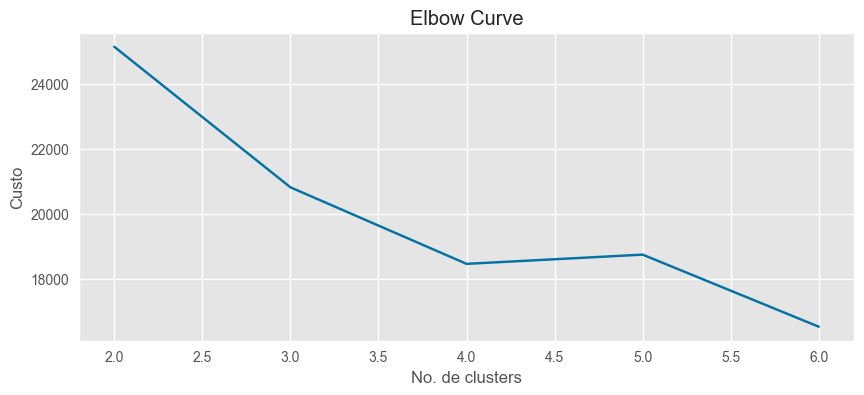

In [204]:
kmodes(2, 6, df_kmodes)

### Métricas

### Ajuste do modelo

In [205]:
k_modes = KModes(n_clusters=3, init='Cao', n_jobs=-1)
k_modes.fit_predict(df_kmodes)

array([0, 0, 0, ..., 1, 0, 0], dtype=uint16)

In [218]:
df['kmodes_3clusters'] = k_modes.labels_

In [219]:
df['kmodes_3clusters'].value_counts()

kmodes_3clusters
0    7788
1    4337
2    1752
Name: count, dtype: int64

### Verificando características dos clusters

In [221]:
df.select_dtypes('number').groupby('kmodes_3clusters')[['Monetary_value_sum', 'delivery_fee_sum',
                                                        'subsidy_amount_sum', 'Frequency', 'Recency',
                                                        'TempoVida', 'total_order_count']].mean().T

kmodes_3clusters,0,1,2
Monetary_value_sum,955.30,930.38,1217.33
delivery_fee_sum,69.96,45.24,100.32
subsidy_amount_sum,46.45,81.63,34.09
Frequency,14.62,19.80,15.03
Recency,78.93,80.46,72.15
TempoVida,1168.01,1234.03,1414.79
total_order_count,359.82,399.23,450.95


### Insights do modelo

O algoritmo kmodes não nos trouxe uma modelagem util, pois os valores encontrados para cada cluster são muito proximos, não diferenciando de maneira adequada os integrantes de cada grupo.

Podemos tentar outras abordagens como:
- DBSCAN
- Aglomerativo
- Hierarquico
- Affinity propagation
- Gaussian Mixture
- BIRCH
- OPTICS

## DBSCAN

In [230]:
df_dbscan = df_kmeans_robust[['Frequency','Recency','Monetary_value_sum']]

In [243]:
dbscan = DBSCAN(eps = 2, min_samples = 5)

dbscan.fit(df_dbscan)

DBSCAN(eps=2)

In [244]:
labels = dbscan.labels_
silhouette = silhouette_score(df_dbscan, labels)
print(f"Silhouette score: {silhouette:.3f}")

Silhouette score: 0.871


In [245]:
df['dbscan'] = labels

In [246]:
df['dbscan'].value_counts()

dbscan
 0    13779
-1       69
 3       13
 1        6
 4        5
 2        5
Name: count, dtype: int64

# 7.Referencias

- https://towardsdatascience.com/practical-steps-and-considerations-to-successfully-profile-your-customer-base-19f3f0991407

- https://towardsdatascience.com/clustering-algorithms-for-customer-segmentation-af637c6830ac

- https://realpython.com/k-means-clustering-python/

- https://machinelearningmastery.com/clustering-algorithms-with-python/ (exemplos de algorítimos)

- https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html (olhando k-means mais de perto)

- https://towardsdatascience.com/k-means-clustering-in-python-4061510145cc

- https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203

- https://medium.com/the-researchers-guide/generate-numerical-correlation-and-nominal-association-plots-using-python-c8548aa4a663

- https://g4educacao.com/portal/o-que-e-matriz-rfm

- https://medium.com/analytics-vidhya/integrated-approach-of-rfm-clustering-cltv-machine-learning-algorithm-15f9cb3653b0

- https://developer.ibm.com/tutorials/learn-clustering-algorithms-using-python-and-scikit-learn/

- https://towardsdatascience.com/unsupervised-learning-with-k-means-clustering-generate-color-palettes-from-images-94bb8e6a1416

- https://www.analyticsvidhya.com/blog/2021/08/hierarchical-clustering-algorithm-python/

- https://www.analyticsvidhya.com/blog/2022/04/flat-vs-hierarchical-clustering-book-recommendation-system/

- https://www.analyticsvidhya.com/blog/2022/05/adding-explainability-to-clustering/

- https://www.analyticsvidhya.com/blog/2022/11/hierarchical-clustering-in-machine-learning/

- https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7

- https://towardsdatascience.com/k-means-dbscan-gmm-agglomerative-clustering-mastering-the-popular-models-in-a-segmentation-c891a3818e29

- https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/

- https://www.analyticsvidhya.com/blog/2021/06/understand-the-dbscan-clustering-algorithm/

- https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/

- https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2